## Natural Language Processing with RNNs 

### Project and Dataset information


This dataset contains the a csv file transcript of the Apple event live stream held in September 2023. It includes three fields: "Text," representing the verbatim transcript; "Start Time," indicating when each segment of text begins; and "Duration," specifying the duration of each spoken segment.
There are 1349 rows and 3 columns with no null value. Only text column is used for this script character RNN project to predict the next token.


Reference: https://www.kaggle.com/datasets/nuhmanpk/apple-event-september-2023-transcript

### Import functions

In [18]:
# Collapse-show
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings('ignore')

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


## Load and Explore Data

In [19]:
data = pd.read_csv('mozilla_common_voice.csv') # load csv dataset
data.tail(10) # Check data from the last 10 rows

,en_text,th_text
33787,An idle man is the devil's playfellow.,คนที่ไม่ได้ทำงานคือเพื่อนเล่นของปีศาจ
33788,Diligence is the mother of good luck.,ความขยันหมั่นเพียรเป็นแม่ของโชคดี
33789,Don't try kicking against the wind.,อย่าพยายามเตะกับลม
33790,Hard work never did anyone any harm.,การทำงานหนักไม่เคยทำอันตรายใครเลย
33791,"If at first you don't succeed, try, try again.",ถ้าครั้งแแงรกคุณทำไม่สำเร็จพยายามลองอีกครั้ง
33792,"If you can't help, don't hinder.",หากคุณไม่สามารถช่วยได้อย่าขัดขวาง
33793,It's all in a days work.,ทำงานทั้งวัน
33794,Laziness travels so slowly that poverty soon o...,ความเกียจคร้านเดินทางช้ามากจนความยากจนมาถึงในไ...
33795,Pushchairs can be folded when the toddler want...,สามารถพับเก็บเก้าอี้ลงได้เมื่อทารกต้องการเดิน
33796,Quantum computing machines are rare and hard t...,เครื่องคำนวณควอนตัมทั้งนั้นหายากและผลิตได้ยาก


In [20]:
data.info # Check summary of the dataset

<bound method DataFrame.info of                                                  en_text  \
0                The fool wanders, the wise man travels.   
1               One of these days is none of these days.   
2      Necessity is a hard nurse, but she raises stro...   
3                          In one ear and out the other.   
4      It can't happen here is number one on the list...   
...                                                  ...   
33792                   If you can't help, don't hinder.   
33793                           It's all in a days work.   
33794  Laziness travels so slowly that poverty soon o...   
33795  Pushchairs can be folded when the toddler want...   
33796  Quantum computing machines are rare and hard t...   

                                                 th_text  
0                            คนโง่พเนจร คนฉลาดท่องเที่ยว  
1               หนึ่งในวันเหล่านี้คือไม่มีวันเหล่านี้เลย  
2      ความจำเป็นเป็นสิ่งที่ยาก, แต่เธอสามารถเลี้ยงลู...  
3          

In [21]:
data.isnull().sum() # Check how many null value

en_text    0
th_text    0
dtype: int64

In [22]:
print(data.th_text[40:50]) # Print only th(Thai language) column from row 40 to 50

40                                  ท่านหมายถึงฉันหรือ?
41               คุณอาจจะไถลตัวลงมาและนำมันมา จะได้ไหม？
42                       คุณต้องไม่ทำให้มันยากนะ กัสซี่
43                            คุณจำเป็นต้องคุยกับตัวเอง
44               คุณต้องเหยียบคันเร่งเพื่อไปให้เร็วขึ้น
45                        คุณจำเป็นต้องยืนยันการคัดค้าน
46                            คุณต้องคลิกขวาเพื่อดูเมนู
47    คุณต้องคอยให้มีเสียงสัญญาณโทรศัพท์ก่อนแล้วจึงค...
48    คุณคิดว่า เหล็กเสียบเนื้อย่างนั้นเสียหายจนเห็น...
49                      คุณอยากเล่นเกมโอเอ็กซ์หรือเปล่า
Name: th_text, dtype: object


## Creating the Training Dataset

In [23]:
df = pd.DataFrame(data)
df['th_text'] = df['th_text'].str.lower() # convert all text into lowercase

In [24]:
newData = df['th_text'].iloc[0:].str.cat(sep=' ') # concat all texts from text column
newData # Display text

'คนโง่พเนจร คนฉลาดท่องเที่ยว หนึ่งในวันเหล่านี้คือไม่มีวันเหล่านี้เลย ความจำเป็นเป็นสิ่งที่ยาก, แต่เธอสามารถเลี้ยงลูกที่เข็งแรงได้ เข้าหู้ข้างหนึ่งและออกอีกข้างหนึ่ง ไม่สามารถเกิดขึ้นที่นี่ได้คือคำพูดสุดท้ายที่ดังบนลิสต์ ความจริงไม่ได้หายไปเพราะถูกเมิน ความภาคภูมิมาก่อนที่จะล้ม ไม่มีคนโง่อย่างเช่นคนแก่ อย่าใช้สิ่งวันนี้ถ้าต้องการวันพรุ่งนี้ ไม่มอง ไม่พูด ไม่รู้ ในเมื่อไม่มี จะสูญเสียได้อย่างไร อย่ารีบทำในสิ่งที่ยังไม่สามรถทำได้ เสียงเหมือนกับกระดิ่ง หลักฐานการกินพุดดิ่ง เพื่อเพิ่มการดูถูกการบาดเจ็บ คุณไม่ได้รับเค้กและไม่สามรถกินมันได้เช่นกัน คุณไม่ควรเข้าไปยุ่งกับไข่คน ข่าวร้ายมาอย่างรวดเร็ว ทำอย่างที่ฉันพูดไม่ใช่อย่างที่ฉันทำ อย่าออกไปครึ่งไก่ ไม่กี่คำพูดหลายการกระทำ อย่าโฆษณา: บอกเรื่องซุบซิบ หากคุณไม่พูดคุณจะไม่ต้องถอนคำตอบ ฟังหม้อที่เรียกว่ากาต้มน้ำดำ ไม่มีอะไรจะพูดถ้ามันไม่ได้ป่วย พูดสิ่งที่คุณหมายถึงแล้วนึกถึงสิ่งที่คุณพูด ความเงียบคือการรักษาการทำให้เสียชื่อเสียง หยุดเต้นรอบ ๆ พุ่มไม้ มาร์ช แฮร์ปฏิเสธออกมา อลิสบอกว่า ไม่รู้ว่าคุณพูดถึงเรื่องอะไร เธอบอกว่า ไม่รู้ว่าคุณหมายความว่า

In [25]:
# Split text by character-level tokenization and set all characters to lowercase
text_vec_layer = tf.keras.layers.TextVectorization(split="character", standardize="lower")

# Adapt the TextVectorization layer to the data in "newData" to learn the vocabulary
text_vec_layer.adapt([newData]) 

# Store encoded text data in "newData" using the adapted TextVectorization layer
encoded = text_vec_layer([newData])[0] 

In [26]:
encoded -= 2  # Drop tokens 0 (pad) and 1 (unknown), which we will not use
n_tokens = text_vec_layer.vocabulary_size() - 2  # Number of distinct characters
dataset_size = len(encoded)  # Total number of characters

In [27]:
n_tokens # Represent  distinct characters

135

In [28]:
dataset_size # Total number of characters

1274760

In [29]:
# Function to prepare sequences for training by converting them into a suitable TensorFlow 
# dataset format with batching, shuffling, and target creation. 
def to_dataset(sequence, length, shuffle=False, seed=None, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window_ds: window_ds.batch(length + 1))
    if shuffle:
        ds = ds.shuffle(6_000, seed=seed)
    ds = ds.batch(batch_size)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

In [30]:
# Convert a text input into a dataset of fixed-length sequences using TextVectorization.
list(to_dataset(text_vec_layer(["ที่"])[0], length=6))

[]

In [31]:
length = 100 # Set the learning character lenght to 100
tf.random.set_seed(42) # Generate random numbers and ensure reproducibility on CPU
train_set = to_dataset(encoded[:54_000], length=length, shuffle=True, # ~90% of the dataset is used for Training set
                       seed=42)
valid_set = to_dataset(encoded[54_000:57_000], length=length) # ~5% of the dataeet is used for Validation set
test_set = to_dataset(encoded[57_000:], length=length) # ~5% of the dataeet is used for Test set

## Building and Training the char-RNN Model

In [32]:
tf.random.set_seed(42) # Generate random numbers and ensure reproducibility on CPU

# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])

# Compile the model with loss, optimizer, and metrics
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

# Create a ModelCheckpoint callback to save the best model during training
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    "my_script_model", monitor="val_accuracy", save_best_only=True)

# Train the model on the training and validation datasets for 10 epochs
history = model.fit(train_set, validation_data=valid_set, epochs=10,
                    callbacks=[model_ckpt])

Epoch 1/10
   1684/Unknown - 86s 49ms/step - loss: 2.5230 - accuracy: 0.3441INFO:tensorflow:Assets written to: my_script_model\assets


INFO:tensorflow:Assets written to: my_script_model\assets


1685/1685 [==============================] - 94s 53ms/step - loss: 2.5228 - accuracy: 0.3441 - val_loss: 2.1714 - val_accuracy: 0.4358
Epoch 2/10
1684/1685 [============================>.] - ETA: 0s - loss: 1.6993 - accuracy: 0.5423INFO:tensorflow:Assets written to: my_script_model\assets


INFO:tensorflow:Assets written to: my_script_model\assets


1685/1685 [==============================] - 92s 54ms/step - loss: 1.6992 - accuracy: 0.5423 - val_loss: 2.2634 - val_accuracy: 0.4406
Epoch 3/10
1685/1685 [==============================] - 112s 66ms/step - loss: 1.4919 - accuracy: 0.5945 - val_loss: 2.3482 - val_accuracy: 0.4327
Epoch 4/10
1684/1685 [============================>.] - ETA: 0s - loss: 1.3843 - accuracy: 0.6207INFO:tensorflow:Assets written to: my_script_model\assets


INFO:tensorflow:Assets written to: my_script_model\assets


1685/1685 [==============================] - 107s 63ms/step - loss: 1.3842 - accuracy: 0.6207 - val_loss: 2.3930 - val_accuracy: 0.4412
Epoch 5/10
1685/1685 [==============================] - 100s 59ms/step - loss: 1.3063 - accuracy: 0.6410 - val_loss: 2.4602 - val_accuracy: 0.4370
Epoch 6/10
1685/1685 [==============================] - 92s 54ms/step - loss: 1.2528 - accuracy: 0.6551 - val_loss: 2.5453 - val_accuracy: 0.4312
Epoch 7/10
1685/1685 [==============================] - 93s 55ms/step - loss: 1.2056 - accuracy: 0.6672 - val_loss: 2.6082 - val_accuracy: 0.4285
Epoch 8/10
1685/1685 [==============================] - 92s 54ms/step - loss: 1.1629 - accuracy: 0.6795 - val_loss: 2.6767 - val_accuracy: 0.4276
Epoch 9/10
1685/1685 [==============================] - 90s 53ms/step - loss: 1.1430 - accuracy: 0.6852 - val_loss: 2.7253 - val_accuracy: 0.4273
Epoch 10/10
1685/1685 [==============================] - 89s 53ms/step - loss: 1.1000 - accuracy: 0.6981 - val_loss: 2.7764 - val_acc

In [40]:
history.params # Display parameters related tot he traaining process

{'verbose': 1, 'epochs': 10, 'steps': None}

Saving figure keras_learning_curves_plot1


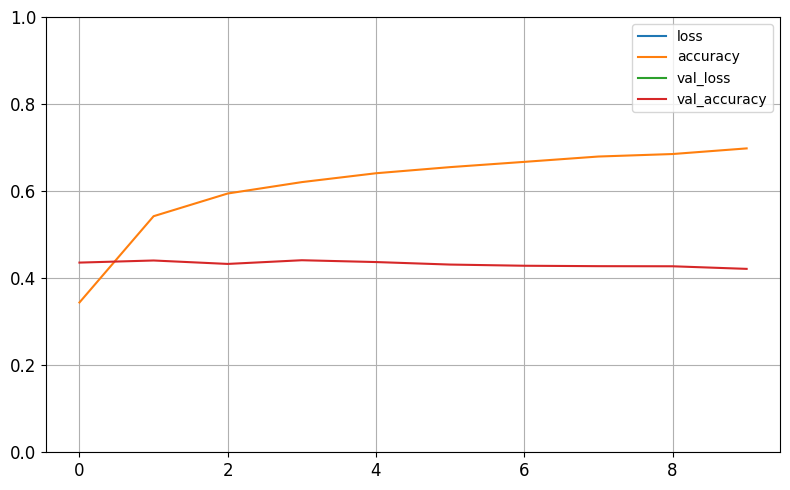

In [41]:
# Display the results of accuracy and loss from the validation set in graph plot
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot1")
plt.show()

## Generating Fake Text

In [46]:
log_probas = tf.math.log([[0.5, 0.4, 0.1]])  # probas = 50%, 40%, and 10%
tf.random.set_seed(42) # Generate random numbers and ensure reproducibility on CPU
tf.random.categorical(log_probas, num_samples=8)  # draw 8 samples

<tf.Tensor: shape=(1, 8), dtype=int64, numpy=array([[0, 1, 0, 2, 1, 0, 0, 1]], dtype=int64)>

In [47]:
my_script_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2),  # no <PAD> or <UNK> tokens
    model
])


In [48]:
# A custom function to randomly generate next character 
def next_char(text, temperature=1):
    y_proba = my_script_model.predict([text])[0, -1:]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1)[0, 0]
    return text_vec_layer.get_vocabulary()[char_id + 2]

In [49]:
# A custom function to randomly generate next 100 characters
def extend_text(text, n_chars, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [50]:
tf.random.set_seed(42) # Generate random numbers and ensure reproducibility on CPU

In [51]:
# Extend 10 characters with temperature at 100 for more random
n_chars10 = 10
print(extend_text("ที่", n_chars10, temperature=100))

1/1 [==============================] - 0s 31ms/step
ที่ำo%+ษ-ฝล.่


In [52]:
# Extend 50 characters with temperature at 1 for more random and less deterministic
n_chars50 = 50
print(extend_text("ที่", n_chars50, temperature=1)) 

1/1 [==============================] - 0s 34ms/step
ที่สุดทำผู้หลังคืดหนัก ทำงานออกไปแต่งชนบรีม ฉันถูกเรี


In [53]:
# Extend 100 characters with temperature at 0.01 for more deterministic
n_chars100 = 100
print(extend_text("ที่", n_chars100, temperature=0.01)) 

1/1 [==============================] - 0s 29ms/step
ที่คุณใช้เขยา ฉันไม่ต้องการทำไม มันเป็นความคิดเห็นที่ไม่สอดต่อ พวกเราจะมีความสุดที่ไรครักของฉัน คุณแม่ข


## Stateless RNN

In [54]:
# Generate sequences of text based on input data using stateless RNN
stateless_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])

In [55]:
# Configure the input shape for the stateless model.
stateless_model.build(tf.TensorShape([None, None]))

In [56]:
# Set weights
stateless_model.set_weights(model.get_weights())

In [57]:
# Creater a new sequential model to test stateless RNN
my_script_model2 = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2),  # no <PAD> or <UNK> tokens
    stateless_model
])

In [70]:
# Tesing with new text "iP" and extend 50 characters
tf.random.set_seed(42) # Generate random numbers and ensure reproducibility on CPU

n_chars = 10
print(extend_text("ประ ", n_chars, temperature=0.1))

1/1 [==============================] - 0s 26ms/step
ประ ฉันหน้าของ


### Summary

The model is able to predict characters/tokens as expected. The lower temperature displays more deterministic characters and the higher temperature displays more random characters. The model used temperature at 0.01, 1 and 100.

Stateless RNN is used for this character RNN model due to its simpler sequence modeling tasks where short-term dependencies are sufficient for accurate predictions.